In [33]:
import src.get_data as get_data
import src.load_data as load
import src.compute_income as ci

import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import datetime 

from keras.callbacks import History 
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model, save_model

import time
from sklearn import metrics
from keras import backend as K 

WINDOW = 22

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8


import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

In [3]:
def build_model(input_shape):
    
    # LSTM NN
    d = 0.2
    model = Sequential()
    
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(128, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="normal",activation='relu'))        
    model.add(Dense(1,kernel_initializer="normal",activation='linear'))
    
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    
    return model

In [36]:
def nextDayPrediction(typeBlockchain, stock):    
    """
    Triggers for plotting
    """
    
    plot = True
    plotHictory = True
    interactiveGrapth = True
    plotForTrain = False
    
    df = get_data.get_data_frame(typeBlockchain, stock)
    df.index  = df.date
    
    x = df[['close']].copy()
    y = df[['close']].copy()
    
    NUM_FEATURES = x.shape[1]
    
    
    x = pd.ewma(x, 2)
    y = pd.ewma(y, 2)

    # scaling data
    scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    x[['close']] = scaler.fit_transform(x)
    y['close'] = y_scaler.fit_transform(y.values.reshape(-1,1))

    x[['cl_2']] = y
       
    # Load data. Split train Test
    X_train, y_train, X_test, y_test = load.load_data(x, WINDOW, train_size= 0.96, TrainTest = True)

    x = x[['close']] ####!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    #X_train, y_train = load.load_data(x, WINDOW, TrainTest = False)
    model = build_model(input_shape=(WINDOW, NUM_FEATURES))

    # training our model

    print('START FIT MODEL...')
    history = History()
    history= model.fit(X_train, y_train, validation_data=(X_test, y_test),  batch_size=32, epochs=500,verbose=0,
              callbacks=[history])
    #model.fit(X_train, y_train, batch_size=32, epochs=500,verbose=1)
        
    today = time.strftime("_%d_%m_%Y")

    pathModel = "../../models/model_1f_" + typeBlockchain + today +".h5"

    save_model(model, pathModel)

    #model = load_model(pathModel)

    # one day prediction. get last batch known data (now we didnt need in y value and can predict it)    
    lastbatch = np.array(x[-WINDOW:])
    pred = model.predict([lastbatch.reshape(1,WINDOW, NUM_FEATURES)])
    pred =  np.array(y_scaler.inverse_transform(pred)) # predicted value

    # now we make dataframe and create row names in date

    lastDate =str(df.last_valid_index()).split('-')
    currentData = datetime.date(int(lastDate[0]),int(lastDate[1]),int(lastDate[2])) + datetime.timedelta(1)
    predictionDate = pd.date_range(currentData, periods=1)
    prediction = pd.DataFrame(pred, columns=["close"], index = predictionDate)

    print (prediction)



    if plotForTrain:

        trainPredict = model.predict(X_train)
        trainPredict = y_scaler.inverse_transform(trainPredict)
        prices = df.close.values.astype('float32')
        prices = prices.reshape(len(prices), 1)
        trainPredictPlot = np.empty_like(prices)
        trainPredictPlot[:, :] = np.nan
        trainPredictPlot[WINDOW:len(trainPredict)+WINDOW, :] = trainPredict
        Actual = pd.DataFrame(prices, columns=["close"], index=df.index).close
        Training = pd.DataFrame(trainPredictPlot, columns=["close"], index=df.date).close
        ActualValues = go.Scatter( x = df.date, y = Actual, name = 'ActualValues')
        TrainingValues = go.Scatter( x = df.date, y = Training, name = 'TrainingValues')

        iplot([ActualValues,TrainingValues])
        plt.show()

    if plot:
        trainPredict = model.predict(X_train)
        testPredict = model.predict(X_test)

        trainPredict = y_scaler.inverse_transform(trainPredict)
        trainY = y_scaler.inverse_transform([y_train])

        testPredict = y_scaler.inverse_transform(testPredict)
        testY = y_scaler.inverse_transform([y_test])
        trainScore = metrics.mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
        print('Train Score: %.2f RMSE' % (trainScore))

        testScore = metrics.mean_squared_error(testY[0], testPredict[:,0]) ** .5
        print('Test Score: %.2f RMSE' % (testScore))

    ############################ income ##############################3
        print ('income ACTUAL: ')
        print (ci.calcDOXOD(testY.reshape(-1,1), ci.classifyALL(testY.reshape(-1,1)))    )

        print ('income PREDICTED: ')
        print (ci.calcDOXOD(testY.reshape(-1,1), ci.classifyALL(testPredict.reshape(-1,1)))    )   
    ############################ number TRUE predicted labels for TREND #######
        print ('% TRUE predicted labels for TREND:')
        quality = np.sum([ci.classifyALL(testY.reshape(-1,1)) == ci.classifyALL(testPredict.reshape(-1,1))])
        print (quality/testPredict.shape[0])

        prices = df.close.values.astype('float32')
        prices = prices.reshape(len(prices), 1)
        trainPredictPlot = np.empty_like(prices)
        trainPredictPlot[:, :] = np.nan
        trainPredictPlot[WINDOW:len(trainPredict)+WINDOW, :] = trainPredict

        testPredictPlot = np.empty_like(prices)
        testPredictPlot[:, :] = np.nan
        testPredictPlot[(len(prices) - testPredict.shape[0]):len(prices), :] = testPredict

        plt.plot(pd.DataFrame(prices, columns=["close"], index=df.index).close, label='Actual')
        plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=df.index).close, label='Training')
        plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=df.index).close, label='Testing')
        plt.legend(loc='best')
        plt.show()

        interactiveGrapth = 1
        if interactiveGrapth:

            Actual = pd.DataFrame(prices, columns=["close"], index=df.index).close
            Training = pd.DataFrame(trainPredictPlot, columns=["close"], index=df.index).close
            Testing = pd.DataFrame(testPredictPlot, columns=["close"], index=df.index).close
            
            ActualValues = go.Scatter( x = df.index, y = Actual, name = 'ActualValues')
            TrainingValues = go.Scatter( x = df.index, y = Training, name = 'TrainingValues')
            TestingValues = go.Scatter( x = df.index, y = Testing, name = 'PredictedValues')

            iplot([ActualValues,TrainingValues, TestingValues])
            plt.show()

        if plotHictory:

            plt.plot(history.history['loss'], label = 'TrainLoss')
            plt.plot(history.history['val_loss'], label = 'TestLoss')
            plt.legend()
            plt.show()
        del model

        K.clear_session()
    return_df = pd.DataFrame(Testing.dropna(), index=Testing.dropna().index.to_datetime()).append(prediction)
    return_df.to_csv("../../models/model_1f_" + typeBlockchain + today +".csv")
    
    return prediction

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning:

pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(com=2,min_periods=0,adjust=True,ignore_na=False).mean()

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning:

pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(com=2,min_periods=0,adjust=True,ignore_na=False).mean()



START FIT MODEL...
                  close
2017-08-05  2689.274658
Train Score: 17.32 RMSE
Test Score: 110.10 RMSE
income ACTUAL: 
[ 773.86452941]
income PREDICTED: 
[ 572.97935761]
% TRUE predicted labels for TREND:
0.75


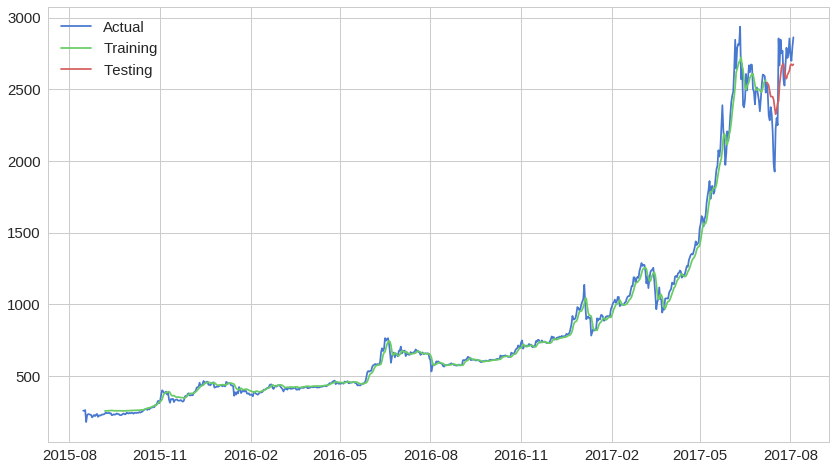

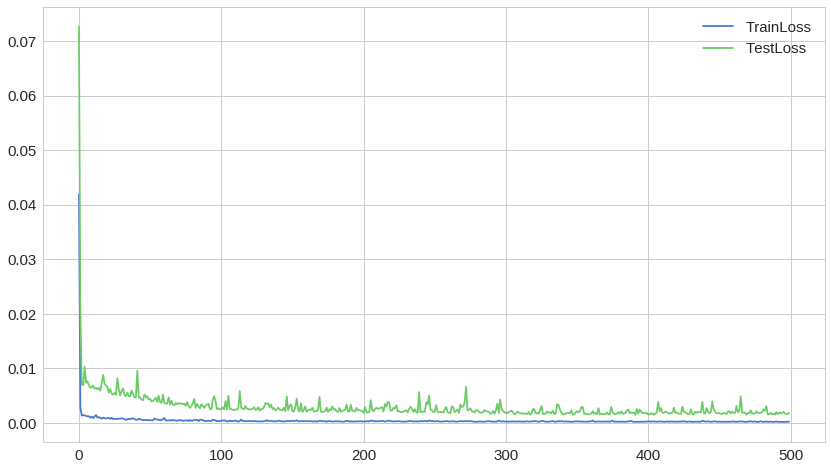

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:153: FutureWarning:

to_datetime is deprecated. Use pd.to_datetime(...)



In [37]:
USDT_BTC = nextDayPrediction('USDT_BTC', 'poloniex')

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning:

pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(com=2,min_periods=0,adjust=True,ignore_na=False).mean()

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning:

pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(com=2,min_periods=0,adjust=True,ignore_na=False).mean()



START FIT MODEL...
                close
2017-08-05  42.067398
Train Score: 0.45 RMSE
Test Score: 1.60 RMSE
income ACTUAL: 
[ 5.28002618]
income PREDICTED: 
[ 0.52964359]
% TRUE predicted labels for TREND:
0.642857142857


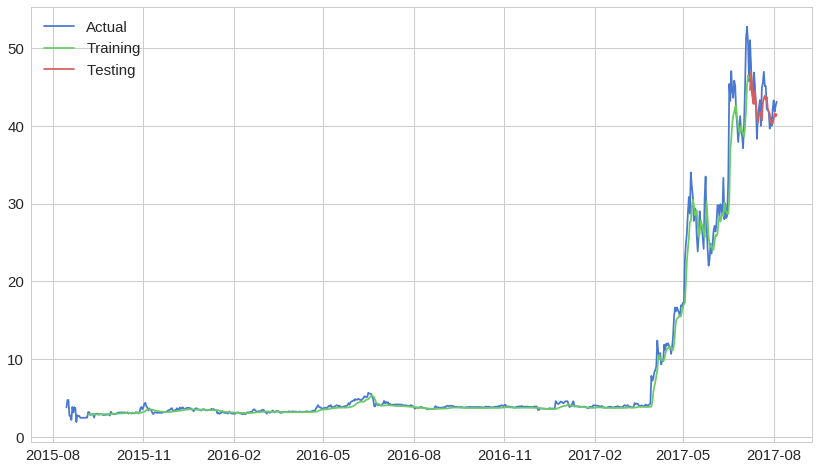

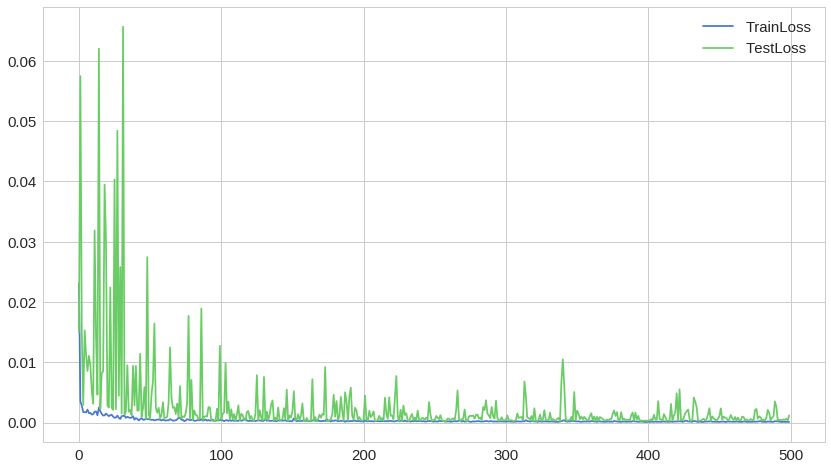

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:153: FutureWarning:

to_datetime is deprecated. Use pd.to_datetime(...)



START FIT MODEL...
                 close
2017-08-05  267.389221
Train Score: 2.43 RMSE
Test Score: 53.46 RMSE
income ACTUAL: 
[ 55.33355231]
income PREDICTED: 
[-22.04264761]
% TRUE predicted labels for TREND:
0.464285714286


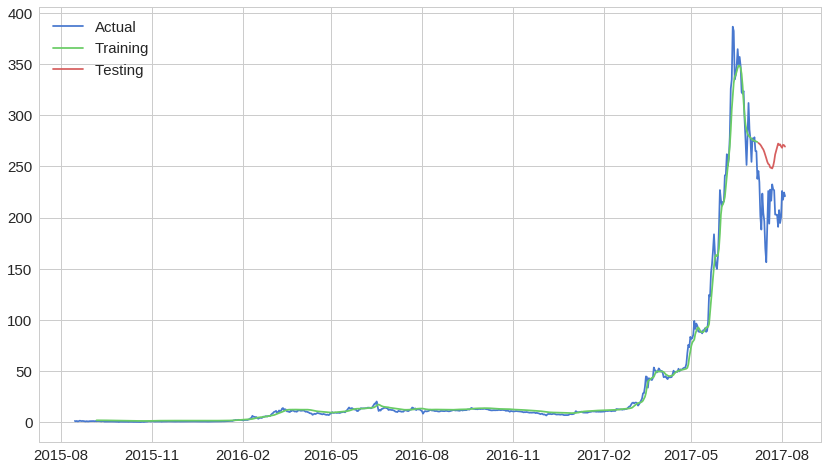

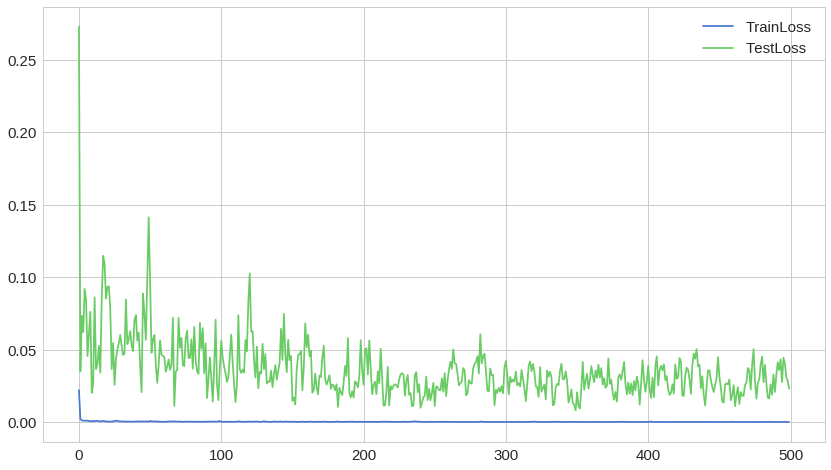

START FIT MODEL...
                close
2017-08-05  16.149685
Train Score: 0.25 RMSE
Test Score: 1.38 RMSE
income ACTUAL: 
[ 0.68645265]
income PREDICTED: 
[ 0.02011405]
% TRUE predicted labels for TREND:
0.857142857143


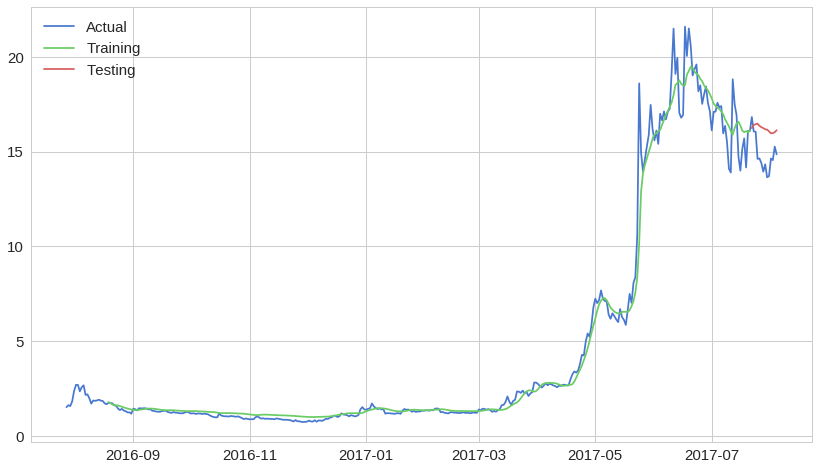

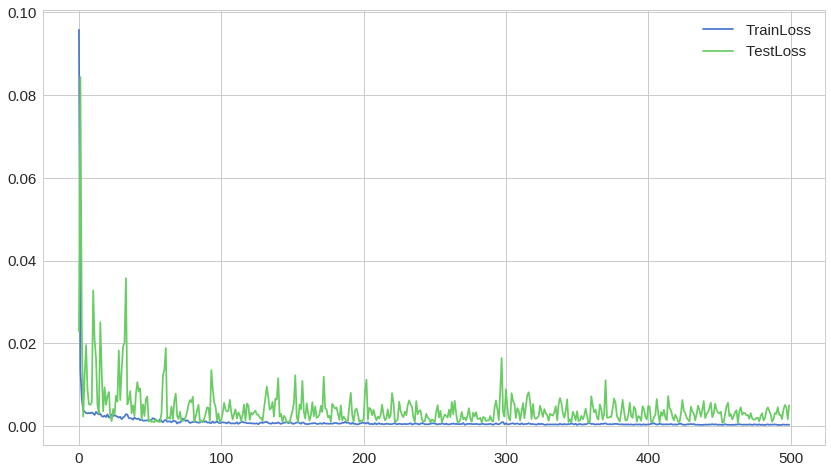

START FIT MODEL...
               close
2017-08-05  0.268013
Train Score: 0.00 RMSE
Test Score: 0.08 RMSE
income ACTUAL: 
[ 0.02255351]
income PREDICTED: 
[-0.01719103]
% TRUE predicted labels for TREND:
0.714285714286


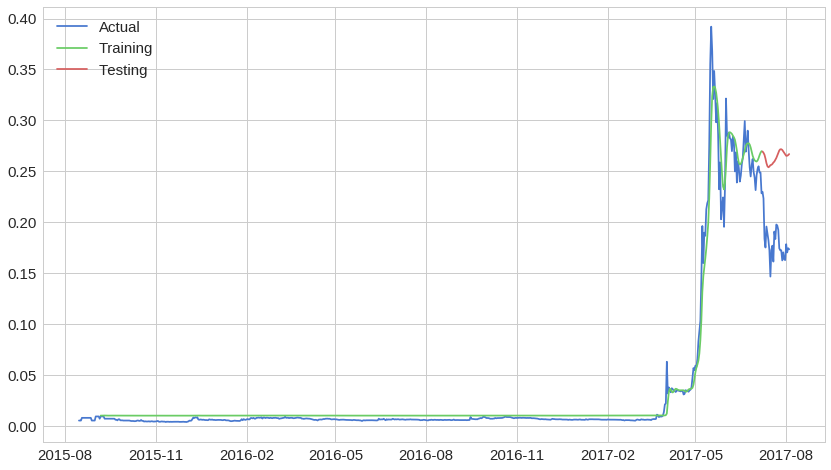

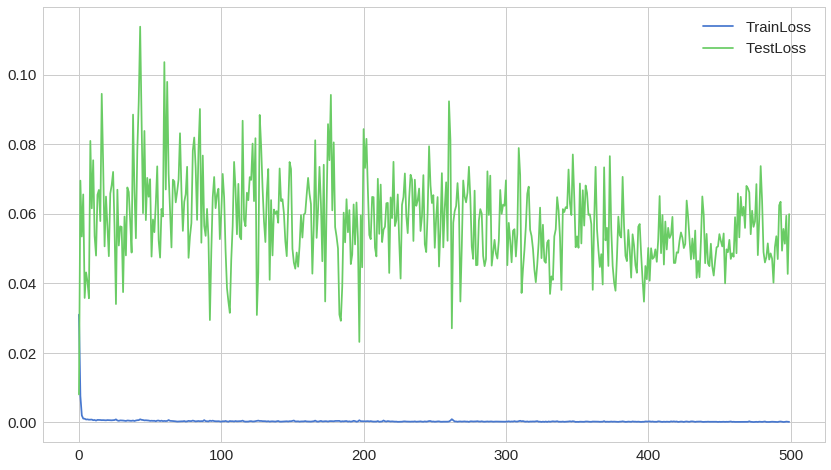

In [38]:
USDT_LTC = nextDayPrediction('USDT_LTC', 'poloniex')
USDT_ETH = nextDayPrediction('USDT_ETH', 'poloniex')
USDT_ETC = nextDayPrediction('USDT_ETC', 'poloniex')
USDT_XRP = nextDayPrediction('USDT_XRP', 'poloniex')